<a href="https://colab.research.google.com/github/francesco-zatto/dia-project/blob/master/car_emissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os.path
from urllib.request import urlretrieve

DATASETS = {
    "car_emissions_spain2022.csv": "https://raw.githubusercontent.com/pietroolivi/dia-datasets/main/car_emissions_spain2022.csv",
    "car_emissions_canada2014.csv": "https://raw.githubusercontent.com/pietroolivi/dia-datasets/main/car_emissions_canada2014/car_emissions_canada2014.csv",
    "car_emissions_uk2013.csv": "https://raw.githubusercontent.com/pietroolivi/dia-datasets/main/car_emissions_uk2013.csv"
}

for filename, dataset in DATASETS.items():
    if not os.path.exists(filename):
      urlretrieve(dataset, filename)

In [3]:
spain_emissions = pd.read_csv("car_emissions_spain2022.csv")
spain_emissions.head(5)

,id,make,model,market_segment,engine_type,consumption_min_l_100km,consumption_max_l_100km,emissions_min_gCO2_km,emissions_max_gCO2_km,transmission,...,avg_wltp_emissions_gCO2_km,length_mm,width_mm,height_mm,gross_vehicle_weight_rating_kg,total_seating,fuel_economy_index,type_hybrid,electric_consumption_kwh_100km,battery_capacity_kwh
0,551266,AIWAYS,AIWAYS U5 MAS861-WVTA/2WB/FL4,Berlinas-Familiares Medios,Eléctricos puros,NaN,NaN,NaN,NaN,A,...,0.0,4680,1865,1700,2135,5,Sin clasificación,NaN,15.75,63.0
1,579684,AIWAYS,AIWAYS U6 PRIME,Berlinas-Familiares Grandes,Eléctricos puros,NaN,NaN,NaN,NaN,A,...,0.0,4805,1880,1641,2290,5,Sin clasificación,NaN,16.00,63.0
2,464453,ALKE,ALKE ATX 310 E plomo acido,Chasis-Cabina Pequeño,Eléctricos puros,NaN,NaN,NaN,NaN,SC,...,0.0,3030,1500,2000,1510,2,Sin clasificación,NaN,11.00,10.0
3,464454,ALKE,ALKE ATX 320 E plomo acido,Chasis-Cabina Pequeño,Eléctricos puros,NaN,NaN,NaN,NaN,SC,...,0.0,3850,1500,2000,1510,2,Sin clasificación,NaN,11.00,10.0
4,464455,ALKE,ALKE ATX 330 E plomo acido,Chasis-Cabina Pequeño,Eléctricos puros,NaN,NaN,NaN,NaN,SC,...,0.0,3850,1500,2000,1510,2,Sin clasificación,NaN,11.00,10.0


In [4]:
canada_emissions = pd.read_csv("car_emissions_canada2014.csv")
canada_emissions.head(5)

,_id,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km)
0,1,1995,Acura,Integra,Subcompact,1.8,4,A4,X,10.2,7.0,8.8,32,202
1,2,1995,Acura,Integra,Subcompact,1.8,4,M5,X,9.6,7.0,8.4,34,193
2,3,1995,Acura,Integra GS-R,Subcompact,1.8,4,M5,Z,9.4,7.0,8.3,34,191
3,4,1995,Acura,Legend,Compact,3.2,6,A4,Z,12.6,8.9,10.9,26,251
4,5,1995,Acura,Legend Coupe,Compact,3.2,6,A4,Z,13.0,9.3,11.3,25,260


In [5]:
uk_emissions = pd.read_csv("car_emissions_uk2013.csv")
uk_emissions.head(5)

C:\Users\Gemma\AppData\Local\Temp\ipykernel_4016\3678210660.py:1: DtypeWarning: Columns (6,30) have mixed types. Specify dtype option on import or set low_memory=False.
  uk_emissions = pd.read_csv("car_emissions_uk2013.csv")


,file,year,manufacturer,model,description,euro_standard,tax_band,transmission,transmission_type,engine_capacity,...,nox_emissions,thc_nox_emissions,particulates_emissions,fuel_cost_12000_miles,fuel_cost_6000_miles,standard_12_months,standard_6_months,first_year_12_months,first_year_6_months,date_of_change
0,DatapartC_july2000.csv,2000,Alfa Romeo,145 Range,1.6 Twin Spark 16v,2,NaN,M5,Manual,1598.0,...,NaN,NaN,NaN,NaN,618.0,NaN,NaN,NaN,NaN,NaN
1,DatapartC_july2000.csv,2000,Alfa Romeo,145 Range,1.8 Twin Spark 16v,2,NaN,M5,Manual,1747.0,...,NaN,NaN,NaN,NaN,633.0,NaN,NaN,NaN,NaN,NaN
2,DatapartC_july2000.csv,2000,Alfa Romeo,145 Range,Cloverleaf,2,NaN,M5,Manual,1970.0,...,NaN,NaN,NaN,NaN,663.0,NaN,NaN,NaN,NaN,NaN
3,DatapartC_july2000.csv,2000,Alfa Romeo,146 Range,1.6 Twin Spark 16v,2,NaN,M5,Manual,1598.0,...,NaN,NaN,NaN,NaN,626.0,NaN,NaN,NaN,NaN,NaN
4,DatapartC_july2000.csv,2000,Alfa Romeo,146 Range,1.8 Twin Spark 16v,2,NaN,M5,Manual,1747.0,...,NaN,NaN,NaN,NaN,633.0,NaN,NaN,NaN,NaN,NaN


# **Esplorazione dei singoli dataset**

# Esplorazione del dataset `spain_emissions`

All'interno del dataset proveniente dal ministero spagnolo sono presenti anche dati riguardanti macchine elettriche. Questa tipologia di dato non è interessante per l'obiettivo del modello, ovvero la quantità di CO2 emessa.

La cella seguente analizza i valori delle righe che hanno `engine_type` "Eléctricos puros", estraendo solo le colonne sul minimo e massimo di consumo di litri di carburante e sul minimio e massimo di emissioni di CO2 per km percorso.

In [6]:
columns = ["emissions_min_gCO2_km", "emissions_max_gCO2_km"]
spain_emissions.loc[spain_emissions["engine_type"] == "Eléctricos puros", columns].isna().all()

emissions_min_gCO2_km    True
emissions_max_gCO2_km    True
dtype: bool

Come era previdibile, tutti i valori delle emissioni di CO2 per km nelle righe riguardanti i veicoli elettrici sono mancanti, quindi le rispettive righe possono essere eliminate, poichè non utili per l'addestramento del modello, il cui obiettivo è la previsione dell'emissione di C02 per veicoli a motore termico.

In [7]:
electric_cars_index = spain_emissions.loc[spain_emissions["engine_type"] == "Eléctricos puros"].index
spain_emissions = spain_emissions.drop(electric_cars_index)

Il dataset contiene tre colonne che rispettivamente indicano le tre dimensioni del motore, ovvero lunghezza, larghezza e altezza in millimetri. Queste tre colonne potrebbero essere delle feature molto importanti per il modello. Quindi è necessario mantenerle nel dataset per motivi di compatibilità con gli altri dataset in una nuova colonna `engine_capacity`, il volume in millimetri cubi, dato dal prodotto delle tre colonne.


In [8]:
spain_emissions["length_mm"] * spain_emissions["width_mm"] * spain_emissions["height_mm"]

31         8842907700
32         8842907700
33         8842907700
34         8842907700
35         8842907700
             ...     
17403     97916000000
17404    124800000000
17405    124800000000
17406     90636000000
17407     90636000000
Length: 15107, dtype: int64

# Esplorazione del dataset `canada_emissions`

All'interno del dataset proveniente dal ministero canadese sono presenti dati riguardanti il tipo di carburante (colonna "Fuel type"). 

La cella seguente conta il numero di occorrenze di ogni lettera nella colonna Fuel type.

In [9]:
canada_emissions["Fuel type"].value_counts()

X    10445
Z     6314
E      770
D      199
N       38
Name: Fuel type, dtype: int64

Riportiamo sotto il significato delle lettere.

- `X`: Benzina normale (ha un indice di ottano più basso ed è quindi meno resistente alla detonazione)
- `Z`: Benzina premium (ha un indice di ottano più alto e offre una maggiore resistenza alla detonazione. È ideale per motori ad alte prestazioni, che hanno un rapporto di compressione                           più elevato e richiedono un carburante più stabile.)
- `D`: Diesel
- `E`: Etanolo(E85)
- `N`: gas naturale

Per motivi di compatibilità dei dataset è superfluo mantenere la distinzione tra benzina normale e benzina premium. Compattiamo quindi le due lettere X e Z in una unica: P (Petrolio).
Per farlo creiamo prima una copia del dataframe così da poter effettuare tutte le doverose modifiche per renderlo confrontabile con gli altri dataset senza perdere o modificare quello iniziale.

In [10]:
canada_emissions_copy = canada_emissions.copy()
canada_emissions_copy["Fuel type"] = canada_emissions_copy["Fuel type"].replace({'X': 'P', 'Z': 'P'})
canada_emissions_copy["Fuel type"].value_counts()

P    16759
E      770
D      199
N       38
Name: Fuel type, dtype: int64

E' inoltre doveroso rimuovere da questo dataset la feature che indica il numero di cilindri del veicolo essendo una colonna presente solo in questo dataframe.

In [11]:
canada_emissions_copy = canada_emissions_copy.drop("Cylinders", axis=1)
canada_emissions_copy.head(5)

,_id,Model year,Make,Model,Vehicle class,Engine size (L),Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km)
0,1,1995,Acura,Integra,Subcompact,1.8,A4,P,10.2,7.0,8.8,32,202
1,2,1995,Acura,Integra,Subcompact,1.8,M5,P,9.6,7.0,8.4,34,193
2,3,1995,Acura,Integra GS-R,Subcompact,1.8,M5,P,9.4,7.0,8.3,34,191
3,4,1995,Acura,Legend,Compact,3.2,A4,P,12.6,8.9,10.9,26,251
4,5,1995,Acura,Legend Coupe,Compact,3.2,A4,P,13.0,9.3,11.3,25,260


Lo stesso ragionamento vale per le feature City e Highway che indicano rispettivamente il consumo di carburante nelle strade di città e nelle autostrade.

In [12]:
canada_emissions_copy = canada_emissions_copy.drop(["Highway (L/100 km)","City (L/100 km)"], axis=1)
canada_emissions_copy.head(5)

,_id,Model year,Make,Model,Vehicle class,Engine size (L),Transmission,Fuel type,Combined (L/100 km),Combined (mpg),CO2 emissions (g/km)
0,1,1995,Acura,Integra,Subcompact,1.8,A4,P,8.8,32,202
1,2,1995,Acura,Integra,Subcompact,1.8,M5,P,8.4,34,193
2,3,1995,Acura,Integra GS-R,Subcompact,1.8,M5,P,8.3,34,191
3,4,1995,Acura,Legend,Compact,3.2,A4,P,10.9,26,251
4,5,1995,Acura,Legend Coupe,Compact,3.2,A4,P,11.3,25,260


Trasformiamo ora la grandezza del motore in cm$^3$ (rinominando quindi la feature Engine size).

In [13]:
canada_emissions_copy = canada_emissions_copy.rename(columns={"Engine size (L)": "Engine size"})
canada_emissions_copy["Engine size"] = canada_emissions_copy["Engine size"] * 1000
canada_emissions_copy.head(5)

,_id,Model year,Make,Model,Vehicle class,Engine size,Transmission,Fuel type,Combined (L/100 km),Combined (mpg),CO2 emissions (g/km)
0,1,1995,Acura,Integra,Subcompact,1800.0,A4,P,8.8,32,202
1,2,1995,Acura,Integra,Subcompact,1800.0,M5,P,8.4,34,193
2,3,1995,Acura,Integra GS-R,Subcompact,1800.0,M5,P,8.3,34,191
3,4,1995,Acura,Legend,Compact,3200.0,A4,P,10.9,26,251
4,5,1995,Acura,Legend Coupe,Compact,3200.0,A4,P,11.3,25,260


### Grafici 
Questa sezione contiene alcuni grafici che evidenziano alcuni aspetti del dataframe risultante `canada_emissions_copy`.

Il seguente grafico a torta mostra la percentuale dei diversi tipi di carburante presi in considerazione. Si può notare che la maggior parte dei dati riguardano veicoli a benzina.

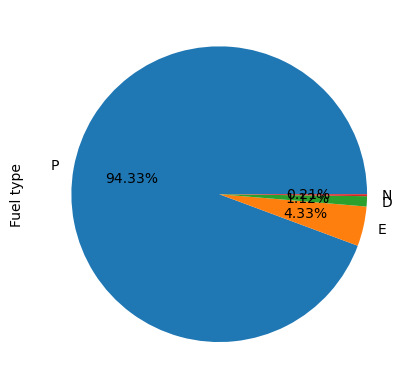

In [32]:
canada_emissions_copy["Fuel type"].value_counts().plot.pie(autopct="%.2f%%")
plt.show()

L'istogramma seguente mostra la distribuzione delle emissioni di CO$_2$ nel dataframe canadese. I valori si concentrano principalmente nell'intervallo [150,350].

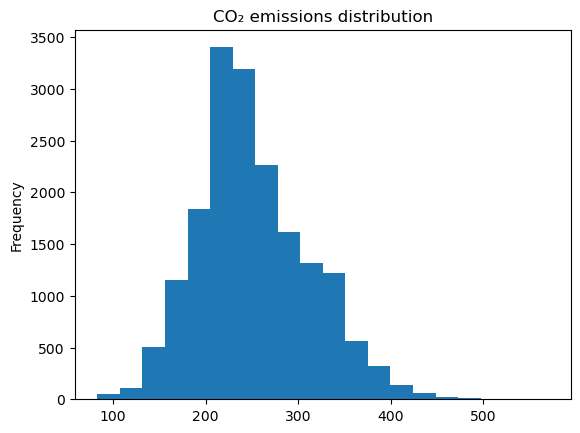

In [18]:
canada_emissions_copy["CO2 emissions (g/km)"].plot.hist(bins=20,title="CO\u2082 emissions distribution");

# **Omogeneizzazione ed unione dei dati**
Avendo reperito tre set di dati ciascuno da una fonte differente, sebbene questi concernano il medesimo dominio e condividano pertanto una considerevole quantità di attributi,

Potremmo essere erroneamente portati a compiere un troncamento delle colonne, conservando esclusivamente quelle appartenenti all'intersezione delle tre tabelle, tuttavia così facendo andremmo a trascurare il caso-limite in cui le features eliminate dovessero essere le uniche legate, attraverso un relazione non randomica, a quella indagata. Una soluzione più scrupolosa consisterebbe, al contrario, nell'unione degli attributi, colmando opportunamente le celle vuote formatesi. In effetti, come visto a lezione, i valori NAN possono essere sostituiti, tra gli altri, da:
- media
- moda
- mediana

In aggiunta, le stesse variabili in comune, malgrado facciano riferimento allo stesso concetto, si manifestano talvolta sotto denominazioni diverse, ed a loro volta i valori corrispondenti da queste assunti potrebbero avere formato dissimile (e.g. capitalizzazione delle lettere nel caso testuale o numero di cifre significative in quello numerico).





